Demographic Issues in PLAICRAFT AI - Equity as a Cornerstone to Building Better AI-powered NPCS
====
![My Image](https://www.pluggedin.com/wp-content/uploads/2020/01/minecraft-review-image-1536x881.jpg)

Introduction
---

In September of 2023, AI Researchers at UBC launched a “free Minecraft in the cloud” AI research data collection project. The project aims to collect 10,000 hours of freely volunteered play time. **Using this data, the lab hopes to create artificially intelligent non-player characters in Minecraft that act like real people. These NPCs would respond to both visual and auditory stimulus, and be able to play in various game modes just like real people** (Smith 2023).



 
Minecraft, a video game released in 2009, has taken the world by storm due to its limitless "sandbox game" design. There is no one right way to play. Minecraft can be played alone or in groups, with friends or online, passively or violently. Some gamemodes involve survival of the fittest, while others, such as "Creative" mode, use the game to build whatever the user wants (Landin 2023).

**Research has shown different demographics approach playing video games differently.** Due to literacy and generational conventions, different age-groups use in-game chat features differently (Ames and Burrell 2017); In studies examining gender differences, girls often played more collaboratively and patiently, while boys were drawn to objective-oriented gameplay modes (Yeh, Lan, and Lin 2018). 


**When specifically considering Minecraft's diverse gamemodes, it makes sense these demographic differences would be refected in users' choices and approaches to limitless options**. 

If PLAICRAFT AI aims to make *realistic* non-player characters, the demographic of its research should be equitable and diverse– and by extension, include all types and approaches to gameplay. We were provided with a dataset which contained seven observations about each of its 196 unique players. Using this, our investigation seeks to better understand the demographic of participants in the research project so far, and ultimately to highlight biases and deficits that might skew the behaviour of PLAICRAFT's AI-Powered NPCs.


More specifically, we'd like to know: 

> Can factors such as self-described experience and age successfully predict the gender of players in this data set?

If these factors are accurate predictors, there would be evidence to suggest that different gender demographics engage with Minecraft differently. If there's evidence of a difference in demographic behaviour, effort should be put towards targeting them equitably for a more realistic AI result. 



Methods & Results:
==
describe the methods you used to perform your analysis from beginning to end that narrates the analysis code.
your report should include code which:
- loads data 
- wrangles and cleans the data to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
note: all figures should have a figure number and a legend


Discussion:
==
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

References:
==
You may include references if necessary, as long as they all have a consistent citation style.

These are the libraries we use for our analysis. Some of them we use for data wrangling, while the others are used for visualization.

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)

EXPLAIN READING OF DATA, removing identifying info

In [112]:

players_full <- read_csv("https://raw.githubusercontent.com/ellailan/PLAICRAFT-Data-Analysis/refs/heads/main/data/players.csv") |>
            select(-hashedEmail, -name) 


players_full

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,Age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17
Pro,TRUE,0.2,Other,NA


EXPLAIN we want to see gender dfistribution

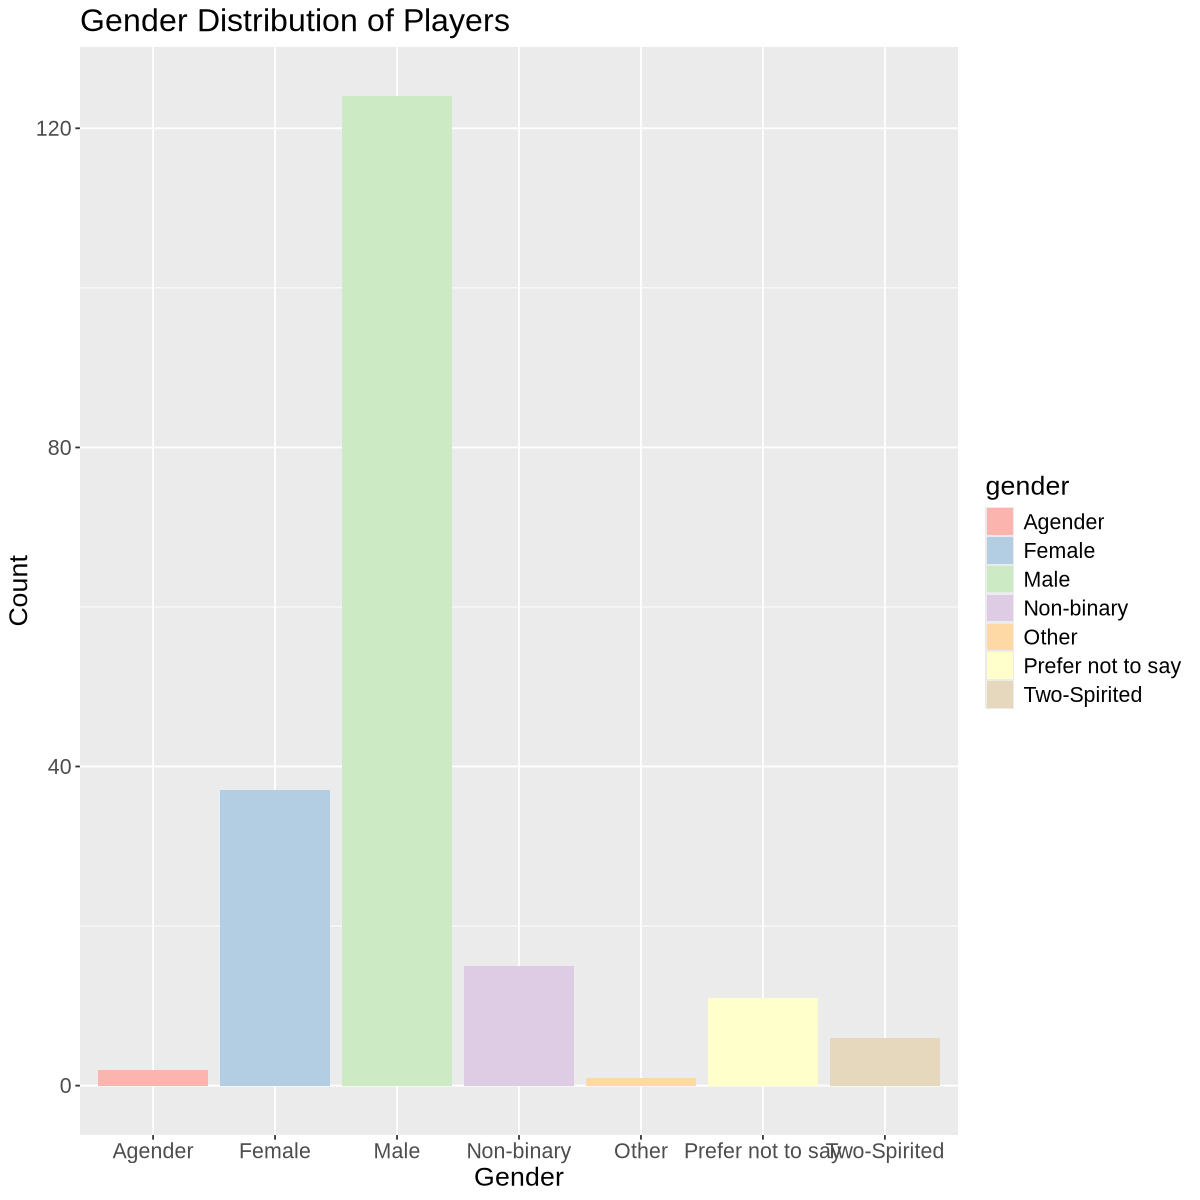

In [108]:
options(repr.plot.width = 10, repr.plot.height = 10) 

gender_full <- players_full |> ggplot(aes(x = gender, fill = gender)) +
  geom_bar() +
  labs(title = "Gender Distribution of Players", x = "Gender", y = "Count") +
    theme(text = element_text(size = 16))  +
    scale_fill_brewer(palette = 'Pastel1')

gender_full

REMOVING GENDERS BC SIMPLE, othger distrubutiions aka age, experience, 

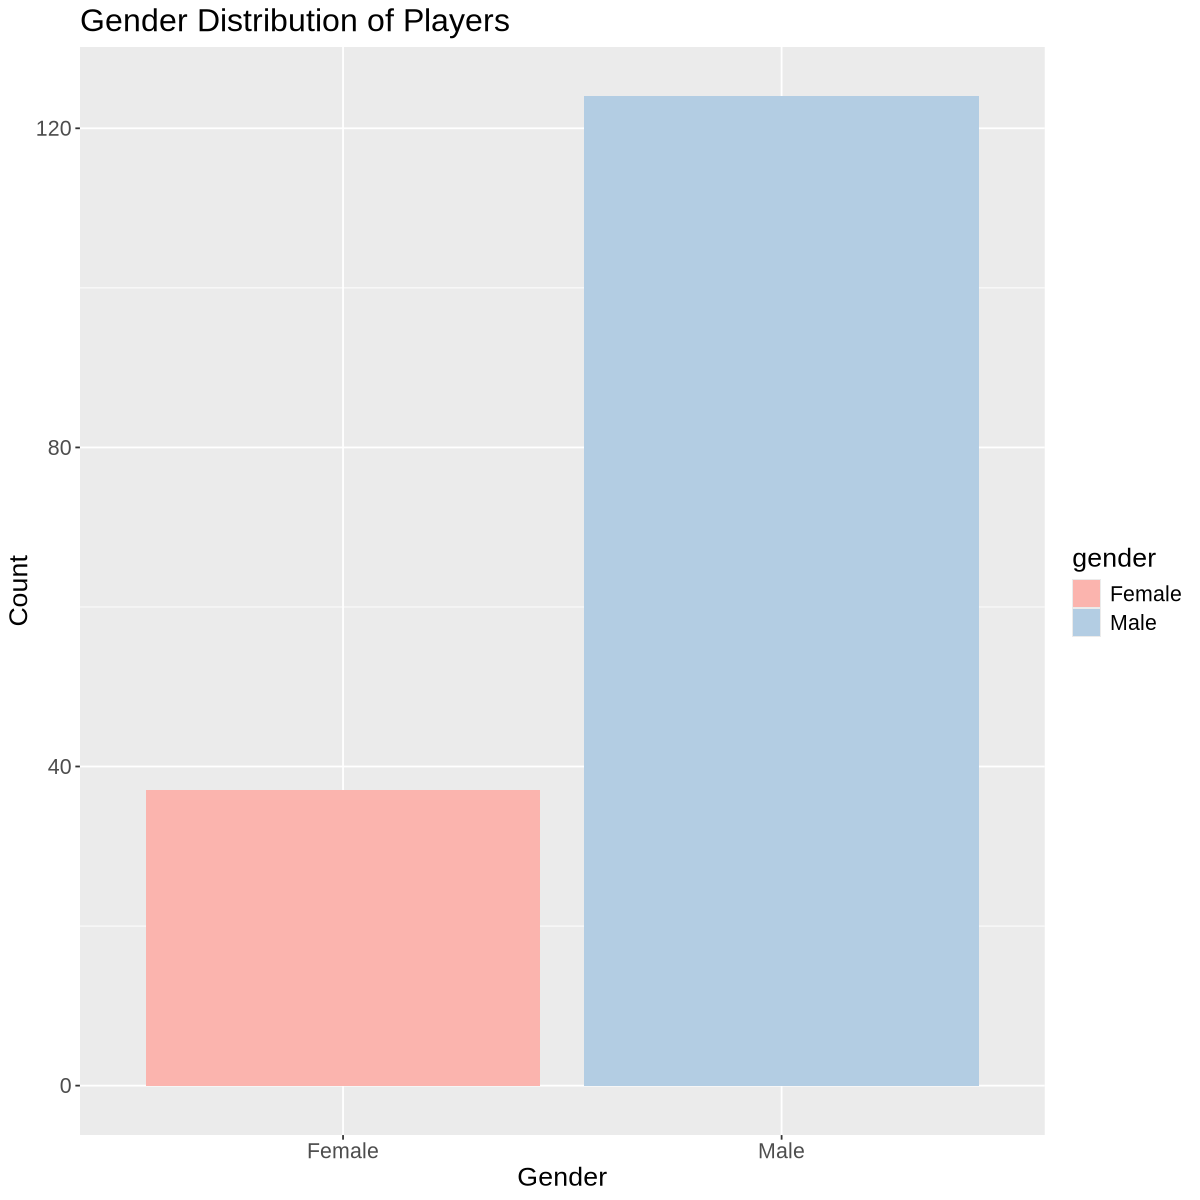

In [109]:

players <- players_full |> filter(gender == "Male" | gender == "Female") 


#visualizing some things that we can see abt. gender makeup of surveyed participants
gender <- players |> ggplot(aes(x = gender, fill = gender)) +
  geom_bar() +
  labs(title = "Gender Distribution of Players", x = "Gender", y = "Count") +
    theme(text = element_text(size = 16))  +
    scale_fill_brewer(palette = 'Pastel1')

gender

##include simple bar graph of experience level counts and histogram of age and also play time

EXPLAIN what was found in graphs, EXPLAIN WE NOW R LOOKING AT DISTRIBUTION ACROSS EXPERIENCE LEVEL

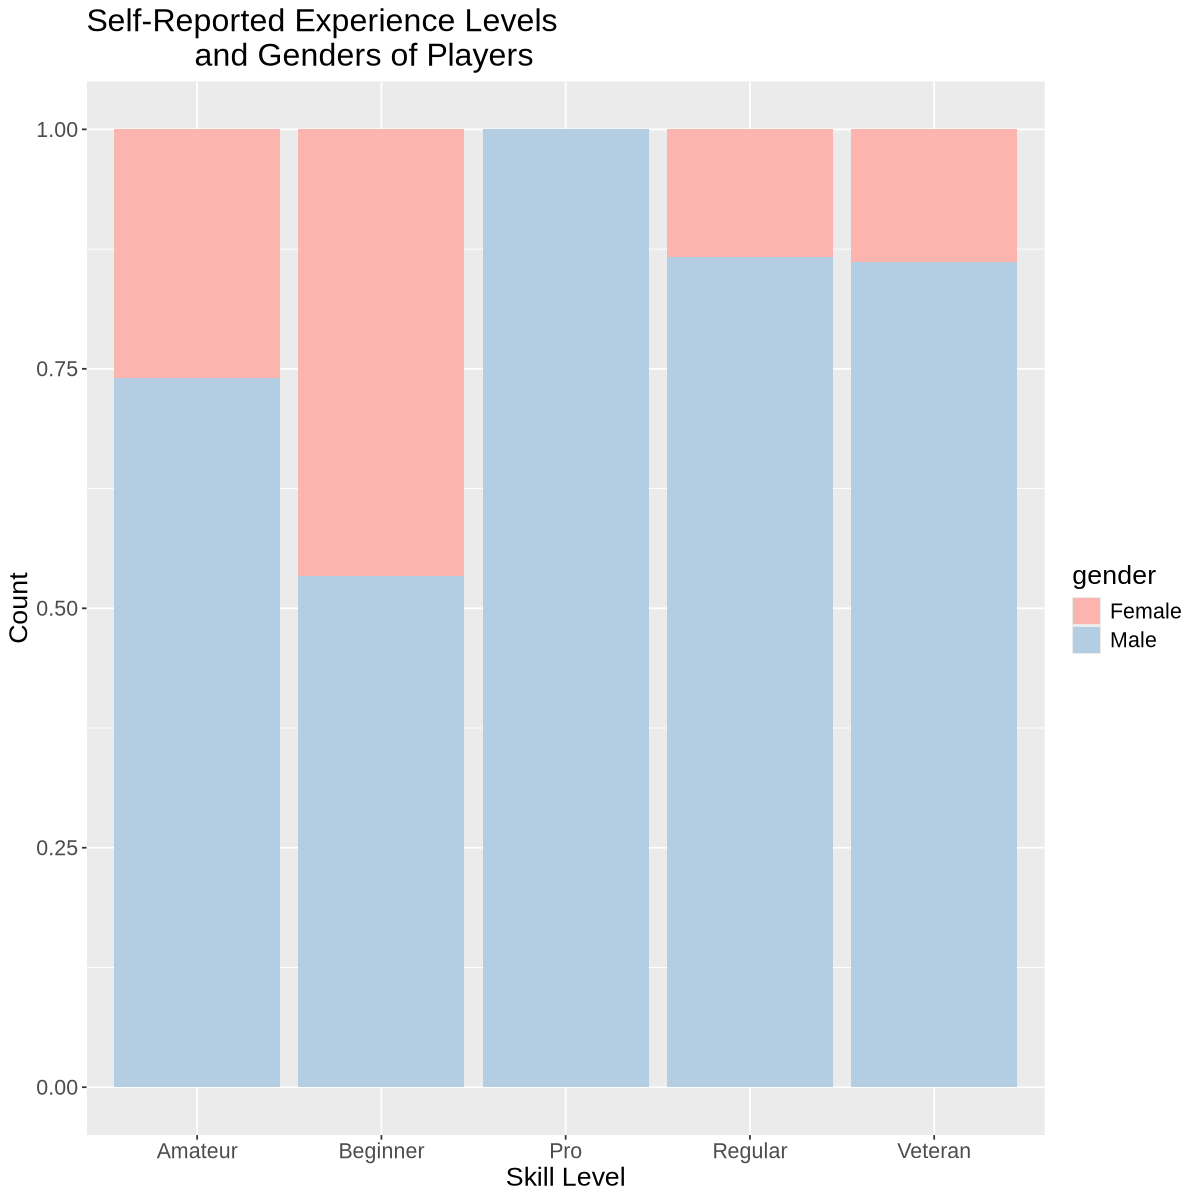

In [105]:

experience_gender <- players |> ggplot(aes(x = experience, fill = gender)) +
  geom_bar(position = "fill") +
  labs(color = "Gender", y = "Count", x = "Skill Level") + 
    ggtitle("Self-Reported Experience Levels
            and Genders of Players") +
    theme(text = element_text(size = 16)) +
    scale_fill_brewer(palette = 'Pastel1')


experience_gender


EXPLAIN UNEVEN DISTRIBUTION, EXPLAIN... MADE NUMBERS FOR CALCULATIONS

In [ ]:


#experience is now scored from 1 to 4, with 1 being the most beginner and 4 being the most advanced
#subscription is now scored from 0 to 1, where 0 is not subscribed and 1 is subscribed
players <- players |>
            mutate(gender = as.factor(gender)) |>
            mutate(experience = as.numeric(factor(experience, 
                                              levels = c("Beginner", "Amateur", "Pro", "Veteran")))) |>
            mutate(subscribe = as.numeric(subscribe))

players <- drop_na(players)



splitting data for testing + training 

In [ ]:

set.seed(1000) 

#splitting data into testing and training, using the proportion reccomended by TA as feedback to proposal 
gender_split <- initial_split(players, prop = 0.80, strata = gender)
gender_train <- training(gender_split)   
gender_test <- testing(gender_split)

VFOLD

In [ ]:
vfold <- vfold_cv(gender_train, v = 2, strata = gender)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

recipe, tune, results

In [ ]:

#excluding playtime bc of outlying data, also debatable
gender_recipe <- recipe(gender ~ experience + subscribe + Age, data = gender_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")


knn_results <- workflow() |>
      add_recipe(gender_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = vfold, grid = k_vals) |>
      collect_metrics() 


accuracy

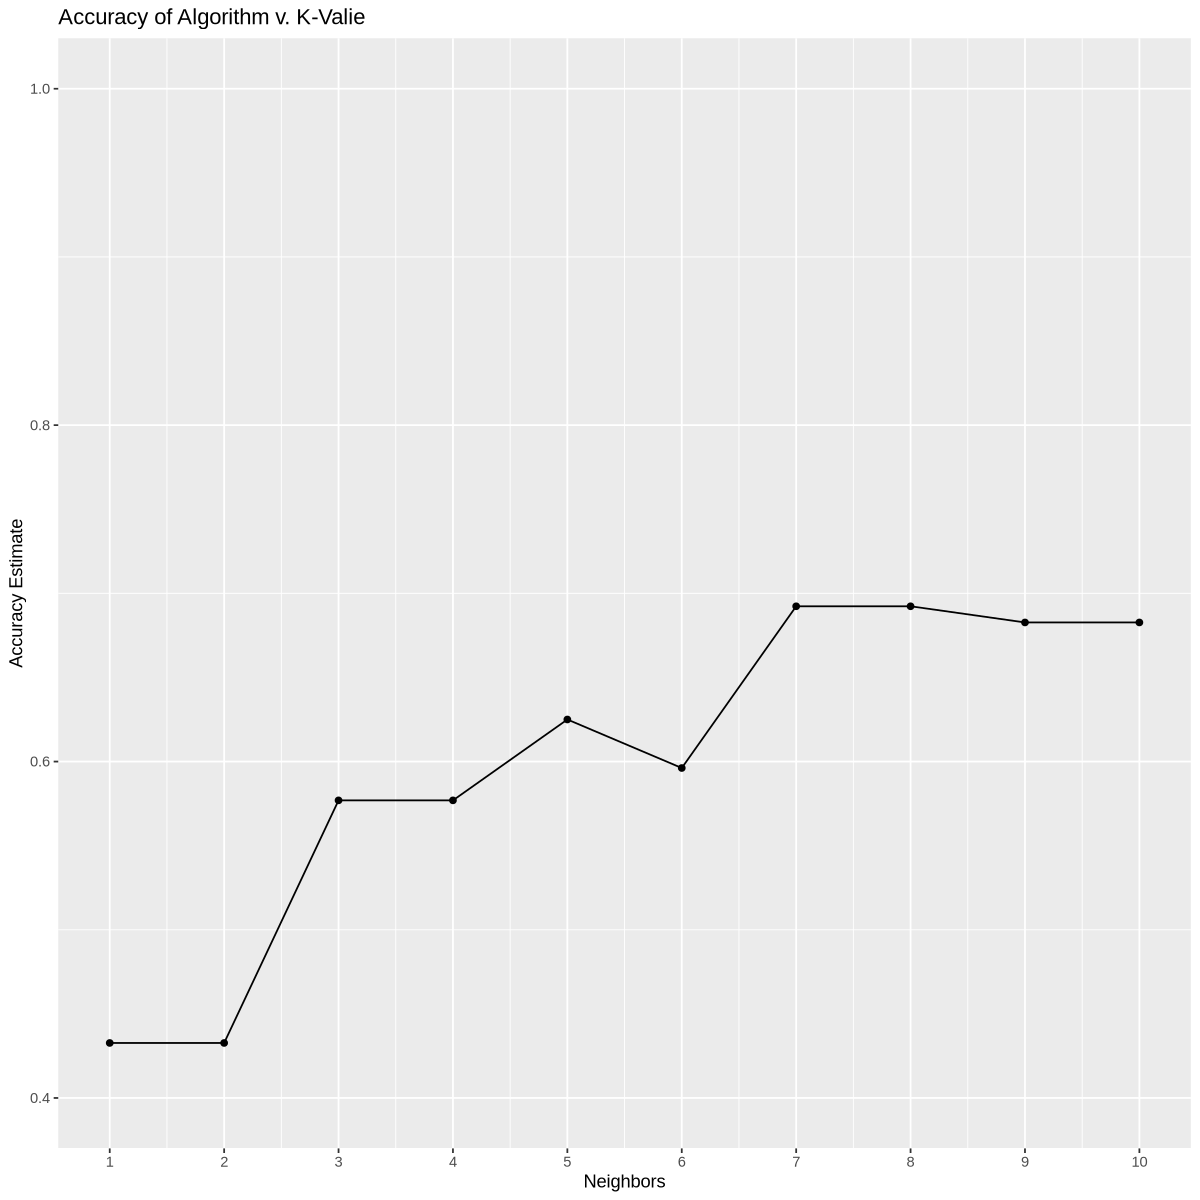

In [110]:

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
      scale_y_continuous(limits = c(0.4, 1.0)) +
        ggtitle("Accuracy of Algorithm v. K-Valie")

accuracy_versus_k

This graph shows a peak at k = 7 in accuracy. We can run the analysis now, setting k = 7, run on test data.

In [111]:
gender_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
      set_engine("kknn") |>
      set_mode("classification")

gender_fit <- workflow() |>
      add_recipe(gender_recipe) |>
      add_model(gender_spec) |>
      fit(data = gender_train)

gender_test_predictions <- predict(gender_fit , gender_test) |>
      bind_cols(gender_test)

gender_test_predictions


.pred_class,experience,subscribe,played_hours,gender,Age
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
Male,2,1,0,Female,17
Male,2,0,0,Male,21
Male,3,1,0,Male,17
⋮,⋮,⋮,⋮,⋮,⋮
Male,2,1,0.8,Female,22
Male,3,0,0.2,Male,17
Male,1,1,0.0,Female,17


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7407407


accuracy of model

In [ ]:
gender_prediction_accuracy <- gender_test_predictions |>
        metrics(truth = gender, estimate = .pred_class) |>
        filter(.metric == "accuracy") 

gender_prediction_accuracy


## References
------------

Ames, Morgan G, and Jenna Burrell. 2017. “‘Connected Learning’ and the Equity Agenda.” *Conference on Computer Supported Cooperative Work,* February. https://doi.org/10.1145/2998181.2998318.

Landin, Per. 2023. “What Is Minecraft.” Minecraft.net. Minecraft. June 5, 2023. https://www.minecraft.net/en-us/article/what-minecraft.

Smith, Andrew. 2023. “Plaicraft.ai Launch - Pacific Laboratory   for Artificial Intelligence.” Pacific Laboratory for Artificial Intelligence. September 28, 2023. https://plai.cs.ubc.ca/2023/09/27/plaicraft/.

Yeh, YiLien, YuJu Lan, and YenTing R Lin. 2018. “GenderRelated Differences in Collaborative Learning in a 3D Virtual Reality Environment by Elementary School Students.” *Journal of Educational Technology & Society* 21 (4): 204–16. https://doi.org/10.2307/26511549.